In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from mordred import Calculator, descriptors
import re

In [5]:
# this data processing script allows incorporation of new acquired data through bcfexpanded
# index_col to avoid importing index as independent column
bcfgen = pd.read_csv('data/dataprocessing/bcfgeneralcommon.csv', index_col=0)
bcfpfas = pd.read_csv('data/dataprocessing/bcfpfas.csv', index_col=0)
bcfexpanded = pd.read_excel('Expanded_BCF.xlsx')

In [6]:
def count_cf_bonds(mol):
    abstract_cf = Chem.MolFromSmarts('C~F')
    cf_bonds = mol.GetSubstructMatches(abstract_cf)
    return len(cf_bonds)

def is_in_dataset(smiles, dataframe=bcfgen):
    # try except
    csmiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
    if csmiles is None:
        print('Failed to construct mol from SMILES:', smiles)
        return False
    else:
        return csmiles in dataframe['cSMILES'].values
    
def expand_dataset(expanded, dataframe):
    expanded['is_in_dataset'] = expanded['SMILES'].map(is_in_dataset)
    print('Existing Compounds:', (expanded.is_in_dataset.values == True).sum())
    print('Novel Compounds:', (expanded.is_in_dataset.values == False).sum())
    
    return expanded[expanded['is_in_dataset'] == False].reset_index(drop=True)
    
def canonicalize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    else:
        return Chem.MolToSmiles(mol)

In [7]:
# Canonicalize SMILES and check for duplicates
bcfgen['cSMILES'] = bcfgen.SMILES.apply(canonicalize)
bcfpfas['cSMILES'] = bcfpfas.SMILES.apply(canonicalize)

# Delete duplicate canonical SMILES
bcfgen.drop_duplicates(subset=['cSMILES'], inplace=True, ignore_index=True)
bcfpfas.drop_duplicates(subset=['cSMILES'], inplace=True, ignore_index=True)

In [13]:
# expand bcfgen with additional datapoints collected from pubchem
novel = expand_dataset(bcfexpanded, bcfgen)

# convert to logBCF and only keep CAS, cSMILES and logBCF
# append to the original nonpfas dataset
novel['cSMILES'] = novel.SMILES.apply(canonicalize)
novel['logBCF'] = np.log10(novel['BCF (L/kg)'])
bcfnew = novel[['CAS', 'cSMILES', 'logBCF']]

# rid any duplicate cSMILES
bcfnew.drop_duplicates(subset=['cSMILES'], inplace=True, ignore_index=True)

# add to bcfgen
bcfgenplus = pd.concat([bcfgen, bcfnew])

Existing Compounds: 169
Novel Compounds: 38


C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [14]:
bcfgenplus

,CAS,logBCF,Dataset,SMILES,cSMILES
0,2691-41-0,-0.300000,uci,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...
1,541-73-1,2.440000,uci,Clc1cc(ccc1)Cl,Clc1cccc(Cl)c1
2,55219-65-3,1.320000,uci,OC(C(Oc1ccc(cc1)Cl)n2ncnc2)C(C)(C)C,CC(C)(C)C(O)C(Oc1ccc(Cl)cc1)n1cncn1
3,55179-31-2/70585-36-3,2.310000,uci,OC(C(Oc1ccc(cc1)c2ccccc2)n3ncnc3)C(C)(C)C,CC(C)(C)C(O)C(Oc1ccc(-c2ccccc2)cc1)n1cncn1
4,5510-99-6,2.470000,uci,Oc1c(cccc1C(CC)C)C(CC)C,CCC(C)c1cccc(C(C)CC)c1O
...,...,...,...,...,...
33,76-01-7,1.826075,NaN,NaN,ClC(Cl)C(Cl)(Cl)Cl
34,95-74-9,1.944483,NaN,NaN,Cc1ccc(N)cc1Cl
35,461-58-5,0.230449,NaN,NaN,N#CN=C(N)N
36,1806-54-8,0.648360,NaN,NaN,CCCCCCCCOP(=O)(OCCCCCCCC)OCCCCCCCC


In [15]:
# remove pfas intersection in bcfgen dataset (10 datapoints)
doubles = pd.merge(bcfgenplus, bcfpfas, how='inner', on=['cSMILES'])
bcfgenplus = bcfgenplus[~bcfgenplus['cSMILES'].isin(doubles['cSMILES'])].reset_index(drop=True)
bcfgenplus

,CAS,logBCF,Dataset,SMILES,cSMILES
0,2691-41-0,-0.300000,uci,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...
1,541-73-1,2.440000,uci,Clc1cc(ccc1)Cl,Clc1cccc(Cl)c1
2,55219-65-3,1.320000,uci,OC(C(Oc1ccc(cc1)Cl)n2ncnc2)C(C)(C)C,CC(C)(C)C(O)C(Oc1ccc(Cl)cc1)n1cncn1
3,55179-31-2/70585-36-3,2.310000,uci,OC(C(Oc1ccc(cc1)c2ccccc2)n3ncnc3)C(C)(C)C,CC(C)(C)C(O)C(Oc1ccc(-c2ccccc2)cc1)n1cncn1
4,5510-99-6,2.470000,uci,Oc1c(cccc1C(CC)C)C(CC)C,CCC(C)c1cccc(C(C)CC)c1O
...,...,...,...,...,...
1113,76-01-7,1.826075,NaN,NaN,ClC(Cl)C(Cl)(Cl)Cl
1114,95-74-9,1.944483,NaN,NaN,Cc1ccc(N)cc1Cl
1115,461-58-5,0.230449,NaN,NaN,N#CN=C(N)N
1116,1806-54-8,0.648360,NaN,NaN,CCCCCCCCOP(=O)(OCCCCCCCC)OCCCCCCCC


In [16]:
# get mol object using rdkit
bcfgenplus['rd_mol'] = bcfgenplus.cSMILES.apply(Chem.MolFromSmiles)
bcfpfas['rd_mol'] = bcfpfas.cSMILES.apply(Chem.MolFromSmiles)
# bcfpfas[bcfpfas['rd_mol'].isnull()]

In [17]:
# count how many PFAS-like molecules are in bcfgen
bcfgenplus['cf_bonds'] = bcfgenplus.rd_mol.apply(count_cf_bonds)
print('There are ', len(bcfgenplus[bcfgenplus['cf_bonds'] >= 2]), ' PFAS-like (2+ c-f bonds) compounds.')

bcfgenplus.drop(columns=['cf_bonds'], axis=1, inplace=True, errors='ignore')

There are  50  PFAS-like (2+ c-f bonds) compounds.


In [18]:
# combine pfas and general dataset
bcfgenplus["is_pfas"] = False
bcfpfas["is_pfas"] = True

bcfcombined = pd.concat([bcfgenplus, bcfpfas]).reset_index(drop=True)
bcfcombined

,CAS,logBCF,Dataset,SMILES,cSMILES,rd_mol,is_pfas,Chemical
0,2691-41-0,-0.300000,uci,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...,<rdkit.Chem.rdchem.Mol object at 0x0000020B8E0...,False,NaN
1,541-73-1,2.440000,uci,Clc1cc(ccc1)Cl,Clc1cccc(Cl)c1,<rdkit.Chem.rdchem.Mol object at 0x0000020B8E0...,False,NaN
2,55219-65-3,1.320000,uci,OC(C(Oc1ccc(cc1)Cl)n2ncnc2)C(C)(C)C,CC(C)(C)C(O)C(Oc1ccc(Cl)cc1)n1cncn1,<rdkit.Chem.rdchem.Mol object at 0x0000020B8E0...,False,NaN
3,55179-31-2/70585-36-3,2.310000,uci,OC(C(Oc1ccc(cc1)c2ccccc2)n3ncnc3)C(C)(C)C,CC(C)(C)C(O)C(Oc1ccc(-c2ccccc2)cc1)n1cncn1,<rdkit.Chem.rdchem.Mol object at 0x0000020B8E0...,False,NaN
4,5510-99-6,2.470000,uci,Oc1c(cccc1C(CC)C)C(CC)C,CCC(C)c1cccc(C(C)CC)c1O,<rdkit.Chem.rdchem.Mol object at 0x0000020B8E0...,False,NaN
...,...,...,...,...,...,...,...,...
1148,335-76-2,3.889259,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,<rdkit.Chem.rdchem.Mol object at 0x0000020B8E2...,True,PFDA
1149,375-22-4,1.184123,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)F,O=C(O)C(F)(F)C(F)(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x0000020B8E2...,True,PFBA
1150,72629-94-8,4.446706,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,<rdkit.Chem.rdchem.Mol object at 0x0000020B8E2...,True,PFTrDA
1151,307-55-1,4.000000,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,<rdkit.Chem.rdchem.Mol object at 0x0000020B8E2...,True,PFDoDA


In [19]:
mordred = Calculator(descriptors, ignore_3D=False)

mordred_descriptors = mordred.pandas(bcfcombined['rd_mol'])

  5%|███▉                                                                            | 57/1153 [00:05<01:17, 14.15it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 61%|████████████████████████████████████████████████▏                              | 703/1153 [00:24<00:20, 21.82it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 69%|██████████████████████████████████████████████████████▏                        | 791/1153 [00:26<00:11, 31.72it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1047/1153 [00:35<00:02, 38.00it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████████████████████████████████████████████| 1153/1153 [00:39<00:00, 29.51it/s]


In [20]:
# There exists strange missing values!
# convert all to float to get proper NaNs
mordred_descriptors = mordred_descriptors.astype(float)

# bcf mordred before additional cleaning steps
bcf_mordred = pd.concat([bcfcombined, mordred_descriptors], axis = 1)

Text(0.5, 1.0, 'Descriptor NaN Distribution')

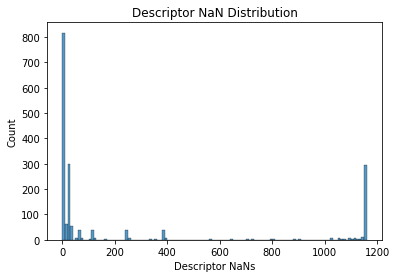

In [26]:
# goal here is to save as many descriptors as possible before doing dropna
# filter for columns that only have few nan values caused by select chemicals, then remove those chemicals
e = mordred_descriptors.isnull().sum().sort_values(ascending=False)
e = e.to_frame(name='NaN Count')

# histogram shows that there are ~300+ descriptors that can be retrieved by removing small number of compounds
ax = sns.histplot(data=e, x="NaN Count", binwidth=10)
ax.set(xlabel = "Descriptor NaNs")
ax.set_title("Descriptor NaN Distribution")

In [31]:
# function that resolves low level error descriptors
def resolve(data, error_table, max_error):
    # searches descriptors with less than max_error NaNs
    # returns list of compounds by index that are responsible for breaking low level error descriptors
    compounds = set()
    for i in range(1, max_error):
        # get all descriptor names
        descriptors = list(error_table[error_table['NaN Count'] == i].index)

        # aggregate all compound indices in those descriptors that are problematic
        for descriptor in descriptors:
            compounds = compounds.union(set(data[data[descriptor].isnull()].index))
        
    return list(compounds)

l = resolve(mordred_descriptors, e, 30)
print('There are', len(l), 'problematic compounds for Mordred descriptors:')
print(l)

# Debugging:
# e[e['NaN Count'] == 4]
# Look for common denominator of these low level errors:
# bcf_mordred[bcf_mordred['Xp-0d'].isnull()]

bcf_mordred.drop(l, inplace=True, errors='ignore')
bcf_mordred.reset_index(drop=True, inplace=True)

There are 49 problematic compounds for Mordred descriptors:
[1027, 1036, 1038, 1039, 1040, 528, 1042, 1043, 1048, 24, 26, 1052, 1053, 1054, 1055, 1056, 1058, 1059, 1060, 1061, 1062, 1063, 809, 1065, 1066, 1073, 1080, 1084, 321, 578, 582, 1095, 583, 584, 585, 1102, 1105, 1110, 1111, 1112, 605, 1119, 1120, 934, 936, 973, 471, 234, 1022]


In [37]:
unfiltered = mordred_descriptors.dropna(axis=1)
print('Originally only', len(unfiltered.columns), 'usable descriptors.')

# Drop all remaining bad descriptors
# How many descriptors do we have left?
bcf_mordred.drop(columns=['SMILES', 'rd_mol', 'Chemical'], axis=1, inplace=True, errors='ignore')
bcf_mordred.dropna(how='any', axis='columns', inplace=True)
print("After resolution, there are now", len(bcf_mordred.columns) - 6, " Mordred descriptors")

Originally only 765 usable descriptors.
After resolution, there are now 1186  Mordred descriptors


In [38]:
# bcf mordred cleaned dataset ready for prediction
bcf_mordred.to_csv('data/bcf_mordred_expanded.csv')

In [41]:
# bcfgen ecfp4 1024, 2048
# ecfp4_1024, 2048
def create_morgan_space(r = 2, nbits = 128):
    def model(mol):
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius = r, nBits = nbits)
    return model

ecfp4_1024 = pd.DataFrame(np.array(bcfcombined.rd_mol.apply(create_morgan_space(r = 2, nbits = 1024)).tolist()).astype(np.float32))
ecfp4_2048 = pd.DataFrame(np.array(bcfcombined.rd_mol.apply(create_morgan_space(r = 2, nbits = 2048)).tolist()).astype(np.float32))

In [42]:
bcf_ecfp4 = pd.concat([bcfcombined, ecfp4_1024], axis = 1)
# bcf_ecfp4.drop(l, inplace=True, errors='ignore')
bcf_ecfp4.reset_index(drop=True, inplace=True)
bcf_ecfp4.drop(columns=['SMILES', 'rd_mol', 'Chemical'], axis=1, inplace=True, errors='ignore')
bcf_ecfp4.to_csv('data/bcf_ecfp4_1024_expanded.csv')

In [43]:
bcf_ecfp4 = pd.concat([bcfcombined, ecfp4_2048], axis = 1)
# bcf_ecfp4.drop(l, inplace=True, errors='ignore')
bcf_ecfp4.reset_index(drop=True, inplace=True)
bcf_ecfp4.drop(columns=['SMILES', 'rd_mol', 'Chemical'], axis=1, inplace=True, errors='ignore')
bcf_ecfp4.to_csv('data/bcf_ecfp4_2048_expanded.csv')